In [7]:
#|default_exp data

# Data

> Functions related to data processing in MOCATML

In [8]:
#|export
import numpy as np
from fastcore.all import *
from tsai.data.preparation import SlidingWindow
from fastai.vision.all import *
from tsai.utils import np_load_compressed

In [9]:
#|export
@delegates(SlidingWindow)
def apply_sliding_window_3d(data, window_len, **kwargs):
    """
        Apply sliding window to 3D data. The data is assumed to have the shape
        (n_samples, n_features, n_time_steps).
        Input:
            data: 3D array
            window_len: int, length of the sliding window
            horizon: int, number of time steps to predict
            kwargs: additional arguments to SlidingWindow
        Output:
            X: 3D array, shape (n_samples, n_features, window_len)
            y: 3D array, shape (n_samples, n_features, horizon)
    """
    sw = SlidingWindow(window_len=window_len, **kwargs)
    # Apply the sliding window to every sample (loop on dimension 0) of the data
    slices = [sw(x) for x in data]
    # Concatenate the slices into single arrays (X and y)
    X = np.concatenate([s[0] for s in slices])
    y = np.concatenate([s[1] for s in slices])
    # In case y is a 2D array (config.horizon = 1), add the time dimension at the end
    if y.ndim == 2:
        y = np.expand_dims(y, -1)
    return X, y

In [10]:
# Test
data = np.random.rand(100, 3, 10)
X, y = apply_sliding_window_3d(data, window_len=4, horizon=1, seq_first=False, 
                               stride=None)
test_eq(X.shape, (200, 3, 4))
test_eq(y.shape, (200, 3, 1))

In [11]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()

In [12]:
#|export
class DensityData:
    def __init__(self, data, lbk, h):
        """
        Args:
            data: The data containing sequences of heatmaps. Shape should be (n_samples, lookback, height, width).
            lbk: Number of input frames to use as history (lookback).
            h: Number of output frames to forecast (horizon).
        """
        self.data = data
        self.n_frames_input = lbk
        self.n_frames_output = h
        self.n_frames_total = self.n_frames_input + self.n_frames_output


    def __getitem__(self, idx):
        """
        Returns a single sample from the dataset, split into input and output sequences.
        """
        seq = self.data[idx]  # Shape: (lookback, height, width)
        input = seq[:self.n_frames_input]
        output = seq[self.n_frames_input:self.n_frames_input + self.n_frames_output]
        
        input_tensor = torch.from_numpy(input).float().unsqueeze(1)  # Add channel dimension
        output_tensor = torch.from_numpy(output).float().unsqueeze(1)  # Add channel dimension

        return input_tensor, output_tensor
    
    def __len__(self):
        return len(self.data)

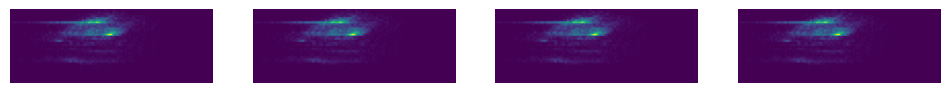

In [13]:
# Test
default_device(False)
data = np_load_compressed('TLE_density_10_15x15.npy.gz', path='../example_data')
lbk = 3
h = 1
ds = DensityData(data, lbk=lbk, h=h)
x, y = ds[0]
test_eq(x.shape, (lbk, 1, 36, 99))
test_eq(y.shape, (h, 1, 36, 99))
z = torch.cat([x, y], dim=0)
show_images(z)


In [14]:
# If you want a fixed one
ds_fixed = [ds[i] for i in range(2)]

# As a Transform

> Refactor into fastai compatible transform

In [15]:
#|export
class DensitySeq(fastuple):
    @classmethod
    def create(cls, t):
        return cls(tuple(im for im in t))    
    def show(self, ctx=None, separator_value=225, **kwargs): 
        # Determine the separator width (number of pixels for the vertical line)
        separator_width = 2
        # Create a separator tensor with a value that stands out (e.g., 1 for white if your heatmap is normalized)
        separator_tensor = torch.full((self[0].size(0), self[0].size(1), separator_width),
                                      separator_value)

        # Create a list to hold the tensors with separators added
        tensors_with_separators = []

        for t in self:
            # Add each tensor and a separator to the list
            tensors_with_separators.append(t)
            tensors_with_separators.append(separator_tensor)

        # Remove the last separator from the list
        tensors_with_separators = tensors_with_separators[:-1]

        # Concatenate the tensors and the separators
        concatenated = torch.cat(tensors_with_separators, dim=2)

        # Use show_image to display the concatenated tensors
        return show_image(concatenated, ctx=ctx, **kwargs)


<Axes: >

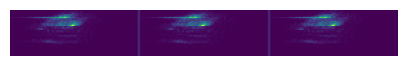

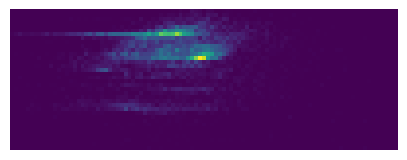

In [16]:
x,y = ds[0]
DensitySeq.create(x).show(figsize=(5,3))
DensitySeq.create(y).show(figsize=(5,3))

In [17]:
#|export
class DensityTupleTransform(Transform):
    def __init__(self, ds):
        self.ds = ds
        
    def encodes(self, idx):
        x,y = self.ds[idx]
        return DensitySeq.create(x), DensitySeq.create(y)

In [18]:
train_tl = TfmdLists([0,1,2,3,4], DensityTupleTransform(ds))
valid_tl = TfmdLists([5,6,7,8,9], DensityTupleTransform(ds))

In [19]:
b = train_tl[0]
explode_types(b)

{tuple: [{__main__.DensitySeq: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {__main__.DensitySeq: [torch.Tensor]}]}

In [20]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=5).to(default_device())

In [21]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.DensitySeq: [torch.Tensor, torch.Tensor, torch.Tensor]},
  {__main__.DensitySeq: [torch.Tensor]}]}

In [22]:
b[0][0].shape

torch.Size([5, 1, 36, 99])

In [23]:
#|export
@typedispatch
def show_batch(x:DensitySeq, y:DensitySeq, samples, ctxs=None, max_n=6, nrows=None, 
               ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n* 1.2)
    if ctxs is None: 
        _, ctxs = plt.subplots(min(x[0].shape[0], max_n), ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        samples[i][0].show(ctx=ctx[0]), samples[i][1].show(ctx=ctx[1])

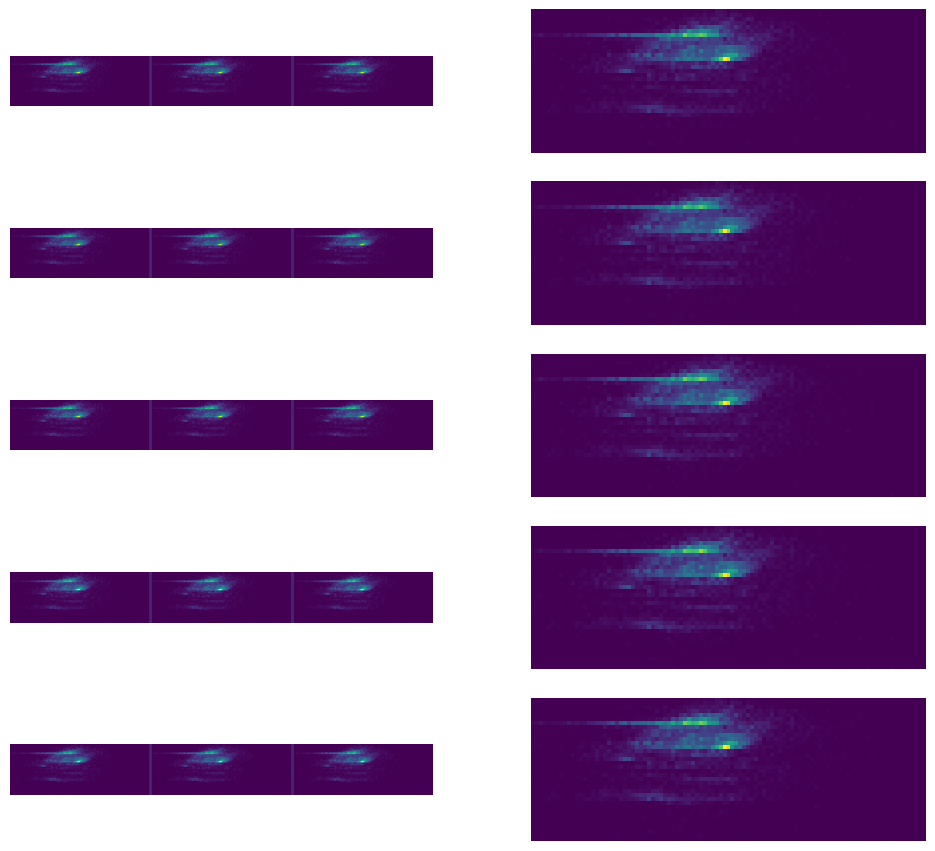

In [24]:
dls.show_batch()